In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import cv2
import PIL
import math
import matplotlib.image as mpimg
from pathlib import Path
import logging

#debug
#%pdb on #https://zohaib.me/debugging-in-google-collab-notebook/


In [2]:
class PathManagement:
    def __init__(self):
        self.__cloud_path_prefix = "/content/drive/My Drive/"
        #########___Data PATH___##############
        #FOR LOCAL DATA:
        #--REAL DATA:
        self._localDataset_metadata = "../data/raw/1channel/reference/epsilon.csv"
        self._localData_root_dir = "../data/raw/1channel/photo/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._localData_metadata_generated_unnoised = "../data/generated/unnoised/reference/epsilon.csv"
        self._localData_root_dir_generated_unnoised = "../data/generated/unnoised/photo/"
        #----NOISED
        self._localData_metadata_generated_noised = "../data/generated/noised/reference/training/epsilon.csv"
        self._localData_root_dir_generated_noised = "../data/generated/noised/photo/training"
        self._localData_metadata_generated_noised_test = "../data/generated/noised/reference/test/epsilon.csv"
        self._localData_root_dir_generated_noised_test = "../data/generated/noised/photo/test"

        #ON DRIVE:
        #--REAL DATA:
        self._cloudDataset_metadata = self.__cloud_path_prefix + "data/reference/real/epsilon_short.csv"
        self._cloudData_root_dir = self.__cloud_path_prefix + "data/photo/real/"
        #--SELF-GENERATED DATA:
        #----UNNOISED
        self._cloudData_metadata_generated_unnoised = self.__cloud_path_prefix + "data/reference/generated/unnoised/epsilon.csv"
        self._cloudData_root_dir_generated_unnoised = self.__cloud_path_prefix + "data/photo/generated/unnoised/"
        #----NOISED
        self._cloudData_metadata_generated_noised = self.__cloud_path_prefix + "data/reference/generated/noised/epsilon.csv"
        self._cloudData_root_dir_generated_noised = self.__cloud_path_prefix + "data/photo/generated/noised/"


        #########___Model PATH___##############
        self.__path_save_model_cloud = self.__cloud_path_prefix + "data/models/"
        self.__path_save_model_local = "../models/"

    def dataPath(self, dataPlace = "local", dataType = "original", isNoise = True):
        """! define correct data path using parameters
        
        @param dataPlace  data place can be 'local' or 'cloud'.
        @param dataType   data type can be 'original' or 'generated'.
        @param isNoise    only used in case of generated dataType.

        @return 2 path --> 1. with methadata, 2. with photo
        """
        if dataPlace == 'local':
            if dataType == 'original':
                return self._localDataset_metadata, self._localData_root_dir
            elif dataType == 'generated':
                if isNoise == False:
                    return self._localData_metadata_generated_unnoised, self._localData_root_dir_generated_unnoised
                else:
                    return self._localData_metadata_generated_noised, self._localData_root_dir_generated_noised
            else:
                return False
        elif dataPlace == 'cloud':
            if dataType == 'original':
                return self._cloudDataset_metadata, self._cloudData_root_dir
            elif dataType == 'generated':
                if isNoise == False:
                    return self._cloudData_metadata_generated_unnoised, self._cloudData_root_dir_generated_unnoised
                else:
                    return self._cloudData_metadata_generated_noised, self._cloudData_root_dir_generated_noised
            else:
                return False
        else:
          return False

    def dataPathTest(self):
        return self._localData_metadata_generated_noised_test, self._localData_root_dir_generated_noised_test

    def modelSavePath(self, dataPlace = "local"):
        """! define model save path depending on the save location
        
        @param dataPlace  data place can be 'local' or 'cloud'.

        @return model save path
        """
        if dataPlace == "local":
            return self.__path_save_model_local
        elif dataPlace == "cloud":
            return self.__path_save_model_cloud
        else: return False


In [3]:
pathManagement=PathManagement()

In [4]:
class Config:
    def __init__(self):
        #Variables to edit
        self.epochs = 20      #number of epochs
        self.num_classes = 1  #num classes in dataset
        #todo zwiekszyc batch_size -> 16 -> 32
        self.batch_size = 4   #batch size used for training (e.g. bath_size photos in one process)
        #todo sprawdzic Adama
        self.learning_rate = 0.001 #for SGD = 0.01, for Adam = 10^-4 -- 10^-3
        self.train_size=0.8
        self.dataset = "InterferometerPhoto"
        #self.architecture = "CNN"
        self.pin_memory = True
        self.momentum = 0.9 #do Adama
        self.step_size = 7
        self.gamma = 0.1
        self.num_workers = 0
        self.model_name_to_save = "1_generated_972997.pth"
        self.data_place = "local" #="cloud"
        self.data_transforms = transforms.Compose([
                        transforms.CenterCrop(448),
                        transforms.Resize(224), #first way is crop and later resize. Second way is CenterCrop right away.
                        #transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.491, 0.491, 0.491],
                                              std=[0.210, 0.210, 0.210]) ])
        self._cuda=True        #GPU = True, CPU = False
        
        #variables not to edit here. You Can edit path in PathManagement Class.
        self.dataset_metadata, self.data_root_dir = pathManagement.dataPath(dataPlace = self.data_place, 
                                                                            dataType = "generated", 
                                                                            isNoise = True)

        self.dataset_metadata_test, self.data_root_dir_test = pathManagement.dataPathTest()
        
        #additional
        self.debug_mode = False

    def device(self):
        if self._cuda == True:
            return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            return "cpu"
        

**Create config data**

In [5]:
config=Config()

**Dataset**

In [6]:
class EpsilonDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file,skiprows=0, delim_whitespace=' ')
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img = np.array(cv2.imread(os.path.join(self.root_dir, str(str("%05d" %self.annotations.imgnr[index]))+ ".png"))).astype(np.float32)
        img=PIL.Image.fromarray(np.uint8(img))
        y_label = self.annotations.eps[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, y_label



In [7]:
def prepare_data(config, train = True):
    #create time logger:
    logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=50) #50 - critical, 40 - error, 30 - warning, 20 - info, 10 - debug, 0 - notset
    logging.debug('1. Start prepare_data')

    if train:
        dataset = EpsilonDataset(config.data_root_dir, config.dataset_metadata, transform=config.data_transforms)
    else:
        dataset = EpsilonDataset(config.data_root_dir_test, config.dataset_metadata_test, transform=config.data_transforms)
    
    g = torch.Generator(device=device).manual_seed(23) 
    loader_params = dict(batch_size=config.batch_size, num_workers=config.num_workers,
                            pin_memory=config.pin_memory, generator=g, shuffle=True)

    if train:
        train_size = int(config.train_size * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g)

        print("len(train_dataset):", len(train_dataset),"len(val_dataset):", len(val_dataset))

        train_loader = torch.utils.data.DataLoader(**loader_params, dataset=train_dataset )
        validation_loader = torch.utils.data.DataLoader(**loader_params, dataset=val_dataset )
        
        return {'train': train_loader, 'val': validation_loader}
    else:
        val_size = int(0)
        test_size = len(dataset)

        test_dataset, val_dataset = torch.utils.data.random_split(dataset, [test_size, val_size], generator=g)

        print("length train dataset:", len(test_dataset))

        test_loader = torch.utils.data.DataLoader(**loader_params, dataset=test_dataset )
        
        return {'test': test_loader}
    

In [ ]:
#import data from drive
from google.colab import drive
drive.mount('/content/drive')

#test connection:
img = mpimg.imread(config.data_root_dir + '03400.png') #test display img')
imgplot = plt.imshow(img)
plt.show()

Load Data

In [8]:
device = "cpu" #first calculations will be on CPU

In [9]:
dataloaders = prepare_data(config)
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

dataset = EpsilonDataset(config.data_root_dir, config.dataset_metadata, transform=config.data_transforms)

train_features, train_labels=next(iter(dataloaders["train"]))

print("Device: ", device)
print("Dataloader train len: ", len(dataloaders["train"]), "val len: ", len(dataloaders["val"]))

len(train_dataset): 3200 len(val_dataset): 800
Device:  cpu
Dataloader train len:  800 val len:  200


In [10]:
device = config.device() #another calculations with default
print("Device: ", device)

Device:  cuda:0


Training the model
------------------




In [20]:
def customLossFunctionDebug(outputs, labels, totalLoss):
    print("NextOne")
    for i in range (len(outputs)):
        print("i: ", i, "label: ", float(labels[i]), "output:", float(outputs[i]), "diff= ", float(min( abs(abs(labels[i])-abs(outputs[i])) , abs(1-(abs(labels[i])-abs(outputs[i]))) )))

    print("totalLoss:", float(totalLoss))
    return totalLoss


def customLossFunction(outputs, labels):
    totalLoss=0.0
    for i in range (len(outputs)):
        #oneOutputLoss= abs(abs(labels[i])-(outputs[i]))
        #oneOutputLoss=min( abs(abs(labels[i])-abs(outputs[i])) , abs(1-(abs(labels[i])-abs(outputs[i]))))
        oneOutputLoss = torch.min( torch.abs(torch.abs(labels[i])-torch.abs(outputs[i])) , torch.abs(1-(torch.abs(labels[i])-torch.abs(outputs[i]))))
        totalLoss+=oneOutputLoss
    totalLoss/=len(outputs)
    #customLossFunctionDebug(outputs=outputs, labels=labels, totalLoss=totalLoss)
    return totalLoss

def singleCustomLossFunction(outputs, labels):
    return torch.min( torch.abs(torch.abs(labels)-torch.abs(outputs)) , torch.abs(1-(torch.abs(labels)-torch.abs(outputs))))

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = -100000
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss+=loss

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            #print("epoch_loss: ", epoch_loss, "running_loss: ", running_loss, "dataset_sizes[phase]: ", dataset_sizes[phase])
            epoch_acc = 1-epoch_loss

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                str(phase), float(epoch_loss), float(epoch_acc)))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_acc)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
device = config.device()
model_ft = models.resnet18(pretrained=True)
#todo mozna sprobowac wiekszego resneta
#todo najpierw uczy sie siec zamrozona i na poczatku uczy sie tylko ostatnie 
#     warstwy i dopiero jak dobrze pojdzie to odmrazamy
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config.learning_rate, momentum=config.momentum)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config.step_size, gamma=config.gamma)
#print((dataloaders['train'])[0])


In [23]:
model_ft = train_model(model=model_ft, criterion=customLossFunction, optimizer=optimizer_ft, scheduler=exp_lr_scheduler,
                       num_epochs=config.epochs)

Epoch 0/19
train Loss: 0.3726 Acc: 0.6274
val Loss: 0.3136 Acc: 0.6864

Epoch 1/19
train Loss: 0.2605 Acc: 0.7395
val Loss: 0.1563 Acc: 0.8437

Epoch 2/19
train Loss: 0.2177 Acc: 0.7823
val Loss: 0.0999 Acc: 0.9001

Epoch 3/19
train Loss: 0.2049 Acc: 0.7951
val Loss: 0.2166 Acc: 0.7834

Epoch 4/19
train Loss: 0.1639 Acc: 0.8361
val Loss: 0.1279 Acc: 0.8721

Epoch 5/19
train Loss: 0.1631 Acc: 0.8369
val Loss: 0.0872 Acc: 0.9128

Epoch 6/19
train Loss: 0.1735 Acc: 0.8265
val Loss: 0.1846 Acc: 0.8154

Epoch 7/19
train Loss: 0.0776 Acc: 0.9224
val Loss: 0.0504 Acc: 0.9496

Epoch 8/19
train Loss: 0.0549 Acc: 0.9451
val Loss: 0.0362 Acc: 0.9638

Epoch 9/19
train Loss: 0.0440 Acc: 0.9560
val Loss: 0.0341 Acc: 0.9659

Epoch 10/19
train Loss: 0.0391 Acc: 0.9609
val Loss: 0.0437 Acc: 0.9563

Epoch 11/19
train Loss: 0.0391 Acc: 0.9609
val Loss: 0.0406 Acc: 0.9594

Epoch 12/19
train Loss: 0.0336 Acc: 0.9664
val Loss: 0.0294 Acc: 0.9706

Epoch 13/19
train Loss: 0.0314 Acc: 0.9686
val Loss: 0.0300 A

**Time to save model**

In [13]:
def saveModel(model, modelName):
    """! function to save model
    
    @param model        model to save
    @param modelName    name of model - prefered pith *.pth
    """
    tempPathToSave = pathManagement.modelSavePath(dataPlace = config.data_place) + modelName #path to save

    torch.save(model_ft, tempPathToSave)
    #torch.save(model.state_dict(), tempPathToSave)
    
    print("model saved: " + config.data_place)


In [30]:
saveModel(model=model_ft, modelName = config.model_name_to_save)

model saved: local


In [13]:
#state_dict = torch.load(pathManagement.modelSavePath(dataPlace = config.data_place) + config.model_name_to_save) #to check, is everything ok
tempPathToLoad = pathManagement.modelSavePath(dataPlace = config.data_place) + config.model_name_to_save

state_dict = torch.load(tempPathToLoad, map_location=device)

del tempPathToLoad
#print(state_dict.keys())

Testowanie

In [19]:
device="cpu"
#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 1)
#
#model_ft = model_ft.to(device)
#model_ft.load_state_dict(torch.load('Conv_RealPhotos_0_9745.pht'))
tempPathToLoad = pathManagement.modelSavePath(dataPlace = config.data_place) + config.model_name_to_save #temporary path
model_ft2=torch.load(tempPathToLoad)
model_ft2.eval()
#dataloaders = prepare_data(config)
dataloaders = prepare_data(config, train=False)
device="cuda"
allDiffs=0.0
j=0
for images, labels in dataloaders['val']:
    images, labels = images.cuda(), labels.cuda()
    outputs=model_ft2(images)
    for i in range(len(outputs)):
        diff=abs(float(labels[i]-outputs[i]))
        allDiffs+=diff
        j+=1
        if (j%100==0): print(j, "mean:", allDiffs/j)
        #print("j:", j, "label: ", float(labels[i]), "output: ", float(outputs[i]), "diff=", diff)

print("mean", allDiffs/j)

length train dataset: 1000


KeyError: 'val'

In [9]:
device="cpu"
#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 1)
#
#model_ft = model_ft.to(device)
#model_ft.load_state_dict(torch.load('Conv_RealPhotos_0_9745.pht'))

tempPathToLoad = pathManagement.modelSavePath(dataPlace = config.data_place) + config.model_name_to_save #temporary path
print(tempPathToLoad)
model_ft2=torch.load(tempPathToLoad)
del tempPathToLoad
model_ft2.eval()
dataloaders = prepare_data(config, train=False)
device="cuda"
allDiffs=0.0
j=0

../models/1_generated_972997.pth
length train dataset: 1000


In [10]:

for images, labels in dataloaders['test']:
    images, labels = images.cuda(), labels.cuda()
    outputs=model_ft2(images)
    for i in range(len(outputs)):
        #diff=abs(float(labels[i]-outputs[i]))
        #diff=singleCustomLossFunction(outputs[i], labels[i])
        diff = float(min( abs(abs(float(labels[i])-abs(outputs[i]))) , abs(1-float((abs(labels[i])-abs(outputs[i]))))))
        allDiffs+=float(diff)
        j+=1
        if (j%100==0): print(j, "mean:", allDiffs/j)
        #print("j:", j, "label: ", float(labels[i]), "output: ", float(outputs[i]), "diff=", diff)

print("mean", allDiffs/j)

100 mean: 0.029641404254361986
200 mean: 0.0260575188184157
300 mean: 0.02613755327028533
400 mean: 0.024401086329016834
500 mean: 0.023372992740944027
600 mean: 0.024596149469725787
700 mean: 0.02407633005641401
800 mean: 0.02410459247912513
900 mean: 0.024811784610824866
1000 mean: 0.02503739626496099
mean 0.02503739626496099


length train dataset: 1000
100 mean: 0.29742526496760546
200 mean: 0.30112930179107933
300 mean: 0.3078657527361065
400 mean: 0.30719027771381663
500 mean: 0.3107645785640925
600 mean: 0.3103082814238345
700 mean: 0.31310643131046423
800 mean: 0.3126825928592007
900 mean: 0.3088751847025317
1000 mean: 0.31056047780555673
0.02144311279213677
0.023913065437227488
0.05118413083255291
0.09122906113043427
0.08197195306420327
0.09714086353778839
0.13113451651904895
0.14036673990388712
0.17095924615859986
0.19206141266557905
0.21096612388888994
0.23547240222493807
0.24545789361000062
0.2726110558618199
0.28975626329580945
0.3063925852378209
0.3233000094240362
0.3423420534684108
0.369391355663538
0.38786552250385287
0.4133444811616625
0.4203948775927226
0.43739440143108366
0.4600172298295157
0.47747664153575897
0.47698695585131645
0.4712672962082757
0.4553517947594325
0.4421181321144104
0.4139946536584334
0.3962491518921322
0.38646844258675206
0.36430650097983225
0.338775098323822
0.3155230879

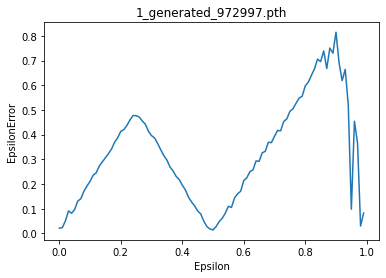

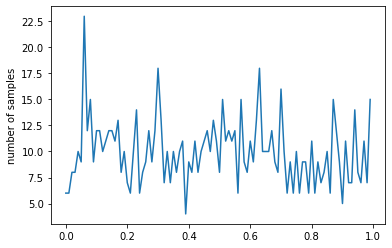

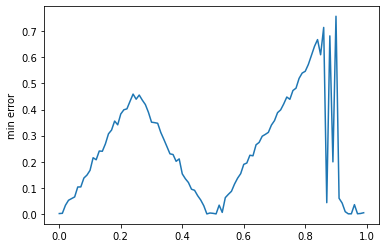

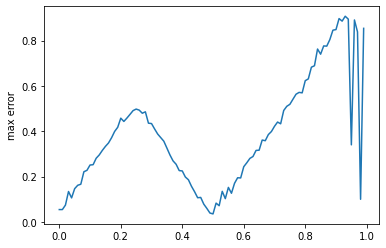

In [14]:
##### with printing charts
class Stats:
    class Bin:
        def __init__(self):
            self.value=0
            self.count=0
        
    
    def __init__(self, binCount):
        self.binAmmount=binCount
        self.bin=self.Bin()
        self.bins=[]

        for i in range(self.binAmmount):
            internalBin=self.Bin()
            self.bins.append(internalBin)

    def CreateBins(self):
        for i in range(self.binAmmount):
            internalBin=self.Bin()
            self.bins.append(internalBin)

    def AddCalculation(self, epsilon, error):
        #print(len(self.bins), int(epsilon/(1/self.binAmmount)), epsilon, error)
        self.bins[int(epsilon/(1/self.binAmmount))].value+=error
        self.bins[int(epsilon/(1/self.binAmmount))].count+=1


device="cpu"

tempPathToLoad = pathManagement.modelSavePath(dataPlace = config.data_place) + config.model_name_to_save #temporary path

model_ft2=torch.load(tempPathToLoad)

del tempPathToLoad

model_ft2.eval()


config.batch_size=1
dataloaders = prepare_data(config, train=False)
device="cuda"
allDiffs=0.0
stats=Stats(100)
j=0

numberOfSamples = np.zeros([100,1],dtype=int) #.
minError = np.ones([100,1],dtype=float)#.
maxError = np.zeros([100,1],dtype=float) #.
tempBinNumber = 0 #.


for images, labels in dataloaders['test']:
    images, labels = images.cuda(), labels.cuda()
    outputs=model_ft2(images)
    for i in range(len(outputs)):
        diff=min(abs(1-abs(float(labels[i]-outputs[i]))) , abs(float(labels[i]-outputs[i])))
        label=copy.deepcopy(float(labels[i]))
        output=copy.deepcopy(float(outputs[i]))
        allDiffs+=diff
        j+=1
        stats.AddCalculation(label, diff)
        #print("label: ", label,"diff: ", diff) #.
        tempBinNumber = int(label*1000 // 10) #.
        numberOfSamples[tempBinNumber] = numberOfSamples[tempBinNumber] + 1 #.
        if minError[tempBinNumber] > diff:
            minError[tempBinNumber] = diff
        if maxError[tempBinNumber] < diff:
            maxError[tempBinNumber] = diff

        if (j%100==0): print(j, "mean:", allDiffs/j)
        #print("j:", j, "label: ", float(labels[i]), "output: ", float(outputs[i]), "diff=", diff)
       
        #plt.imshow(images)
        #plt.show
        #out1 = torchvision.utils.make_grid(inputs)
        #imshow(out1,"abc")

#print(numberOfSamples) #.
x=[]
y=[]

for i in range (len(stats.bins)):
    x.append(1/stats.binAmmount*i)
    if(stats.bins[i].count==0): y.append(0)
    else: 
        y.append(stats.bins[i].value/stats.bins[i].count)
        print(stats.bins[i].value/stats.bins[i].count)
plt.plot(x,y)
plt.title(config.model_name_to_save)
plt.xlabel("Epsilon")
plt.ylabel("EpsilonError")
plt.show()

plt.plot(x, numberOfSamples) #.
plt.ylabel('number of samples') #.
plt.show() #.

plt.plot(x, minError) #.
plt.ylabel('min error') #.
plt.show() #.

plt.plot(x, maxError) #.
plt.ylabel('max error') #.
plt.show() #.
#print("mean", allDiffs/j)

Future ..
---
---
---





In [ ]:
#todo zamrozic i odmrozic .
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()